In [3]:
import tensorflow 
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.layers as layer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf

2025-10-14 21:50:18.069833: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-14 21:50:18.103250: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-14 21:50:18.785938: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [4]:
train_augmentation = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=20,
    zoom_range=0.1,
    horizontal_flip=True,
    width_shift_range=0.1,   
    height_shift_range=0.1 )
train_gen = train_augmentation.flow_from_directory(
        "/home/ocelot/Desktop/CNN_RPS/Archive/train",
        target_size=(100,150),
        batch_size=32,
        class_mode="categorical",
        color_mode="grayscale",
        seed=42

)

val_gen = ImageDataGenerator(rescale = 1./255).flow_from_directory(
    "/home/ocelot/Desktop/CNN_RPS/Archive/validation",
     target_size=(100,150),
     batch_size=32,
     class_mode="categorical",
     color_mode="grayscale",
     seed=42)

    

Found 1531 images belonging to 3 classes.
Found 438 images belonging to 3 classes.


In [5]:
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
model = tensorflow.keras.models.Sequential([
    layer.InputLayer(shape=(100,150,1)),
    layer.Conv2D(32, (3,3), activation='relu', padding='same'),
    layer.Conv2D(32, (3,3), activation='relu', padding='same'),
    layer.MaxPooling2D((2,2)),
    layer.Dropout(0.25),
    layer.Conv2D(64, (3,3), activation='relu', padding='same'),
    layer.Conv2D(64, (3,3), activation='relu', padding='same'),
    layer.MaxPooling2D((2,2)),
    layer.Dropout(0.25),
    layer.Conv2D(128, (3,3), activation='relu', padding='same'),
    layer.Conv2D(128, (3,3), activation='relu', padding='same'),
    layer.GlobalAveragePooling2D(),      
    layer.Dropout(0.5),
    layer.Dense(128, activation='relu'),
    layer.Dense(3, activation='softmax')

])

I0000 00:00:1760471420.599794  113678 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1095 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


In [6]:
%%time
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
history=model.fit(train_gen, epochs=100, callbacks=[early_stop], validation_data=val_gen)

Epoch 1/100


/home/ocelot/env/tf/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-10-14 21:50:24.410463: I external/local_xla/xla/service/service.cc:163] XLA service 0x7bbbf4003030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-14 21:50:24.410473: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti SUPER, Compute Capability 8.9
2025-10-14 21:50:24.499873: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-14 21:50:24.670316: I external/local_xla/xla/stream_executor/cuda/cuda_

11/48 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3201 - loss: 1.1010

I0000 00:00:1760471428.840130  113814 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


29/48 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3239 - loss: 1.1004

2025-10-14 21:50:29.643480: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-14 21:50:29.643507: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-14 21:50:30.017362: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1583', 28 bytes spill stores, 28 bytes spill loads

2025-10-14 21:50:30.122936: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning :

47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.3239 - loss: 1.1003 

2025-10-14 21:50:33.415953: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-14 21:50:33.763576: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_159', 28 bytes spill stores, 28 bytes spill loads

2025-10-14 21:50:33.885462: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-10-14 21:50:33.976192: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memo

48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - accuracy: 0.3174 - loss: 1.1000 - val_accuracy: 0.3311 - val_loss: 1.0986
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3442 - loss: 1.0973 - val_accuracy: 0.3265 - val_loss: 1.0835
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4396 - loss: 1.0000 - val_accuracy: 0.4224 - val_loss: 1.0409
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5624 - loss: 0.7866 - val_accuracy: 0.6438 - val_loss: 0.5670
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6316 - loss: 0.6476 - val_accuracy: 0.6370 - val_loss: 0.7034
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6747 - loss: 0.6066 - val_accuracy: 0.7055 - val_loss: 0.5509
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6891 - loss: 0.5779 - val_accuracy: 0.6279 - val_loss: 0.7624
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6839 - loss: 0.6055 - val_accuracy: 0.7055 - val

In [7]:
test_gen = ImageDataGenerator(rescale = 1./255).flow_from_directory(
    "/home/ocelot/Desktop/CNN_RPS/Archive/test",
     target_size=(100,150),
     batch_size=32,
     class_mode="categorical",
     color_mode="grayscale",
     shuffle=False,
     seed=42)

Found 219 images belonging to 3 classes.


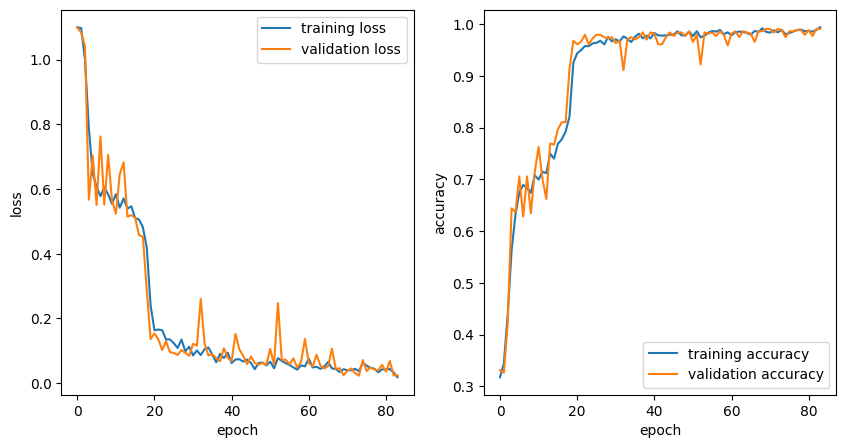

In [8]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10,5)
ax[0].plot(history.history["loss"], label="training loss")
ax[0].plot(history.history["val_loss"], label="validation loss")
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("loss")
ax[0].legend()
ax[1].plot(history.history["accuracy"], label="training accuracy")
ax[1].plot(history.history["val_accuracy"], label="validation accuracy")
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("accuracy")
ax[1].legend()

In [9]:
testLoss, testAccuracy = model.evaluate(test_gen)

1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 0.0153

2025-10-14 21:53:20.338764: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-14 21:53:20.650708: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_159', 28 bytes spill stores, 28 bytes spill loads

2025-10-14 21:53:20.708519: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_159', 28 bytes spill stores, 28 bytes spill loads



7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 1.0000 - loss: 0.0082
